In [3]:
import numpy as np

predictions=np.load("./../../results/data_local/convlstm/predictions.npy")
true=np.load("./../../results/data_local/convlstm/targets.npy")

In [7]:
true.shape

(146, 3, 128, 128)

In [4]:
import warnings
import numpy as np
import matplotlib.pyplot as plt

def plot_mean_hs(predictions, ground_truths, feature_name, channel_idx=0):
    """
    绘制预测和真实值的均值图以及它们的差异图。

    参数：
    - predictions: 4D NumPy 数组，形状为 [时间, 通道, X, Y]
    - ground_truths: 4D NumPy 数组，形状为 [时间, 通道, X, Y]
    - feature_name: 字符串，表示特征的名称
    - channel_idx: 整数，表示通道索引（默认值为0）

    输出：
    - 生成预测、真实值均值图以及差异图
    """
    # 提取指定通道的 hs 数据
    hs_predictions = predictions[:, channel_idx, :, :]
    hs_ground_truths = ground_truths[:, channel_idx, :, :]

    # 将 0 替换为 NaN
    hs_predictions[hs_predictions == 0] = np.nan
    hs_ground_truths[hs_ground_truths == 0] = np.nan

     # 定义安全的均值计算函数
    def safe_nanmean(data, axis):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            return np.nanmean(data, axis=axis)

    # 计算均值
    hs_mean_predictions = safe_nanmean(hs_predictions, axis=0)
    hs_mean_ground_truths = safe_nanmean(hs_ground_truths, axis=0)

    # 计算差异（取绝对值）
    hs_mean_difference = np.abs(hs_mean_predictions - hs_mean_ground_truths)

    # 绘制图像
    fig, axes = plt.subplots(1, 3, figsize=(21, 6))

    # 左图：预测均值
    im1 = axes[0].imshow(hs_mean_predictions, cmap='viridis', origin='lower', aspect='auto')
    axes[0].set_title(f"Mean {feature_name} - Predictions", fontsize=14)
    axes[0].set_xlabel("Grid X")
    axes[0].set_ylabel("Grid Y")
    fig.colorbar(im1, ax=axes[0], label=f"Mean {feature_name}")

    # 中图：真实值均值
    im2 = axes[1].imshow(hs_mean_ground_truths, cmap='viridis', origin='lower', aspect='auto')
    axes[1].set_title(f"Mean {feature_name} - Ground Truths", fontsize=14)
    axes[1].set_xlabel("Grid X")
    axes[1].set_ylabel("Grid Y")
    fig.colorbar(im2, ax=axes[1], label=f"Mean {feature_name}")

    # 右图：差异图
    im3 = axes[2].imshow(hs_mean_difference, cmap='viridis', origin='lower', aspect='auto')
    axes[2].set_title(f"Difference in {feature_name}", fontsize=14)
    axes[2].set_xlabel("Grid X")
    axes[2].set_ylabel("Grid Y")
    fig.colorbar(im3, ax=axes[2], label=f"Absolute Difference ({feature_name})")

    # 显示图像
    plt.tight_layout()
    plt.show()

In [8]:
# 找出array1中值为0的位置索引，返回的是一个元组，每个元素对应相应维度的索引数组
zero_indices = np.where(true == 0)

# 根据索引将array2中对应位置的元素变为0
predictions[zero_indices] = 0

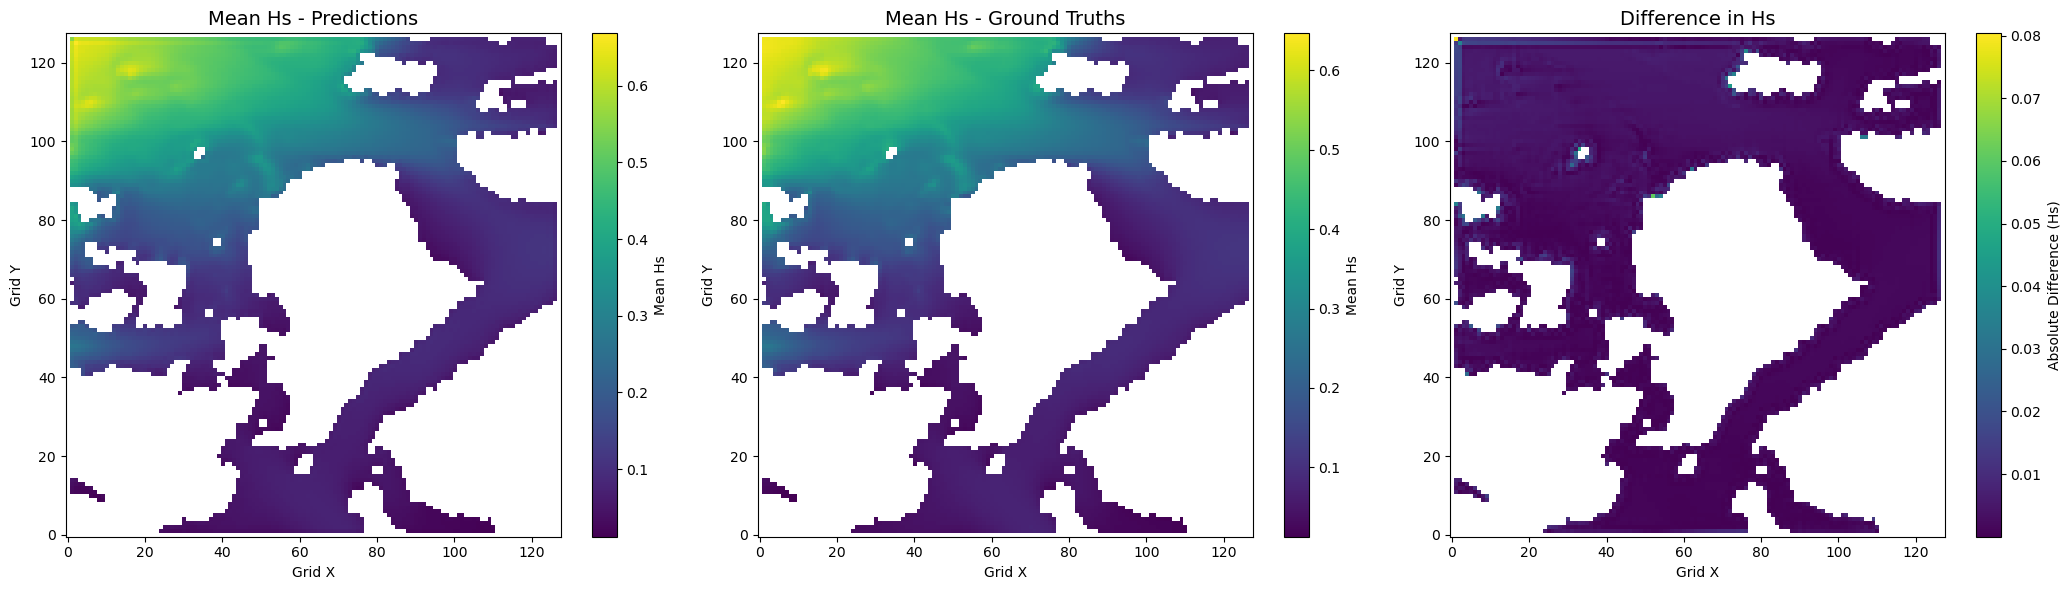

In [9]:
plot_mean_hs(predictions, true, feature_name="Hs", channel_idx=0)

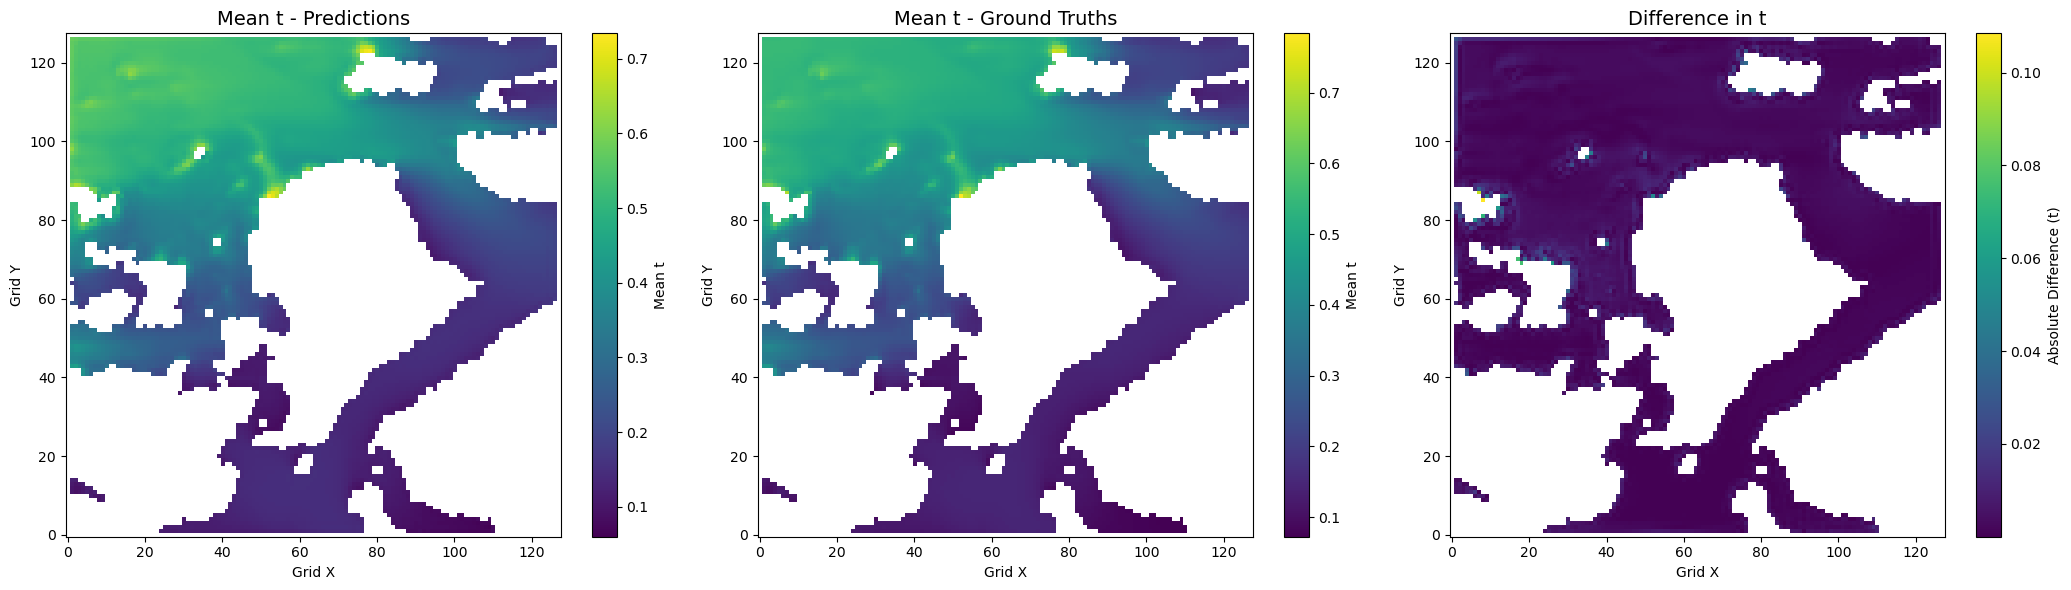

In [10]:
plot_mean_hs(predictions, true, feature_name="t", channel_idx=1)

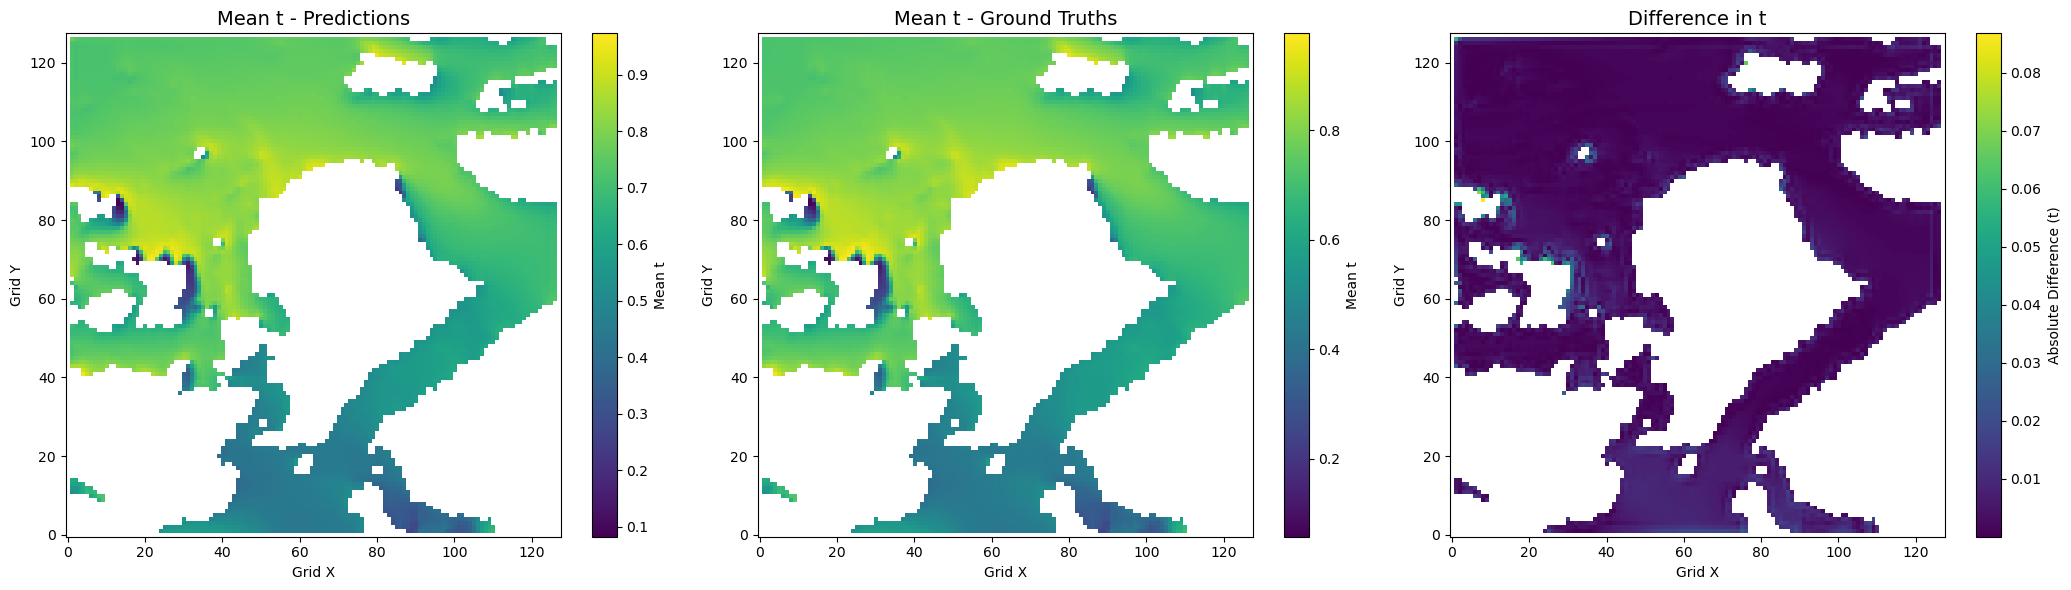

In [11]:
plot_mean_hs(predictions, true, feature_name="t", channel_idx=2)

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_rmse_per_time(predictions, ground_truths, channel):
    """
    计算每个时间点的 RMSE（每个点在时间维度上计算）。

    参数：
    - predictions: 4D NumPy 数组，形状为 [时间, 通道, X, Y]
    - ground_truths: 4D NumPy 数组，形状为 [时间, 通道, X, Y]
    - channel: int，指定通道索引

    返回：
    - time_rmse: 一维数组，表示每个时间点的 RMSE 值
    """
    # 提取当前通道数据
    pred = predictions[:, channel, :]
    truth = ground_truths[:, channel, :, :]

    # 将 0 替换为 NaN，避免无效数据对计算的影响
    pred[pred == 0] = np.nan
    truth[truth == 0] = np.nan

    # 初始化用于存储每个时间点的 RMSE
    time_rmse = []
    # 对每个时间点计算 RMSE
    for t in range(pred.shape[0]):
        pred_c = pred[t, :, :]
        truth_c = truth[t,:, :]

        # 对于方向（dirm1, dirm2），需要计算周期差异 (0-360) 之间的最小差异
        if channel == 2 :  # dirm1 或 dirm2
            diff = np.minimum(np.abs(pred_c - truth_c), 360 - np.abs(pred_c - truth_c))  # 计算周期最小差异
        else:
            diff = np.abs(pred_c - truth_c)  # 对于其他通道，直接计算差异
        
        squared_error = diff ** 2  # 计算平方误差

        total_valid_points = np.sum(~np.isnan(squared_error))  # 非 NaN 点数

        # 计算 RMSE 并归一化
        if total_valid_points > 0:
            mse = np.nansum(squared_error) / total_valid_points
            rmse = np.sqrt(mse)
        else:
            rmse = np.nan
        
        time_rmse.append(rmse)

    return np.array(time_rmse)

def plot_rmse_over_time(predictions, ground_truths):

     # 预定义颜色列表
    colors = ['b', 'g', 'r']  # 蓝色、绿色、红色、青色

    # 创建一个 4 行 1 列的子图，绘制 4 个通道的 RMSE
    fig, axes = plt.subplots(3, 1, figsize=(12, 8))  # 调整高度，确保上下排列
    channel_name=['Hs','Tm','dirm']
    for channel in range(3):  # 对每个通道绘制
        # 计算每个时间点的 RMSE
        time_rmse = calculate_rmse_per_time(predictions, ground_truths, channel)

        # 绘制 RMSE 折线图
        axes[channel].plot(time_rmse, label=f"RMSE - Channel {channel_name[channel]}", color=colors[channel])
        axes[channel].set_title(f"RMSE Over Time - Channel {channel} ({channel_name[channel]})", fontsize=14)
        axes[channel].set_xlabel("Time Step")
        axes[channel].set_ylabel("RMSE")
        axes[channel].legend()
        axes[channel].grid(True)
        # 设置 y 轴从 0 开始
        axes[channel].set_ylim(0, np.max(time_rmse) + 0.1)  # +0.1 给 y 轴上限留点空白
    plt.tight_layout()  # 自动调整布局，防止子图重叠
    plt.show()

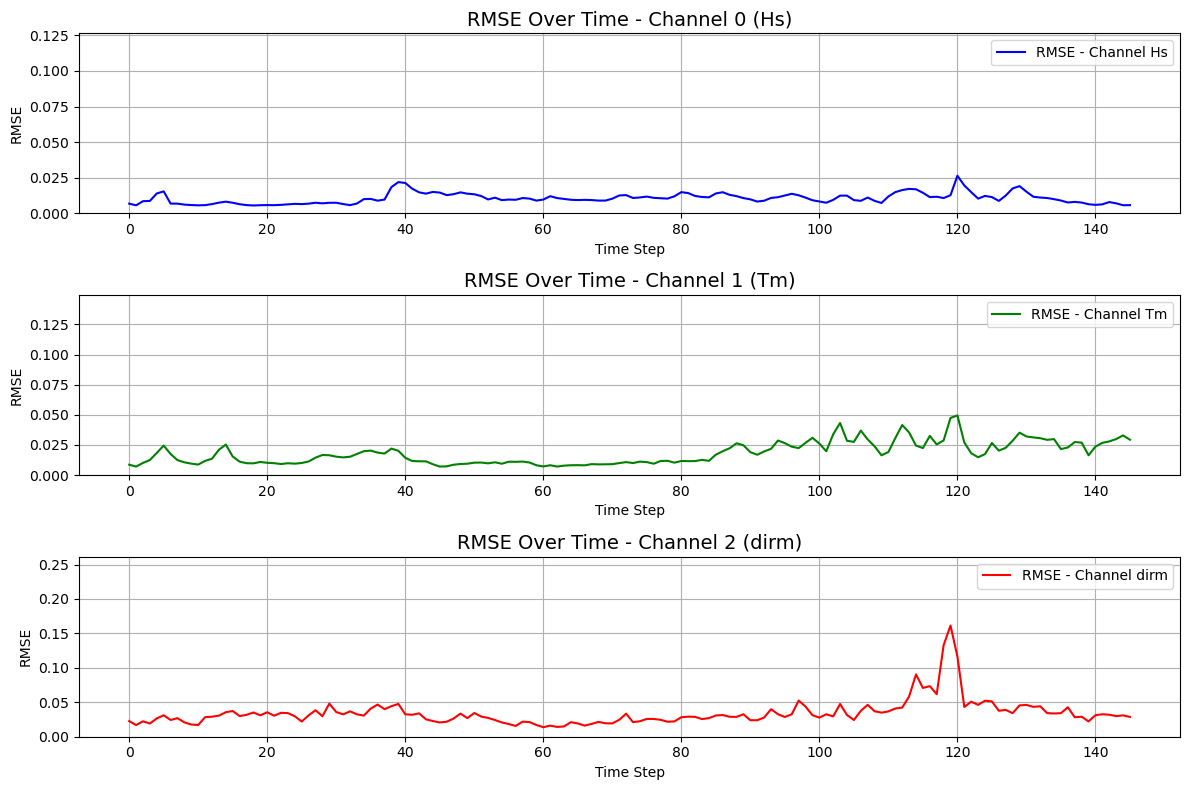

In [13]:
plot_rmse_over_time(predictions, true)

In [16]:
true[0:3, 0, 50:55, 50:55]

array([[[       nan,        nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan,        nan],
        [       nan,        nan, 0.0402027 , 0.03911357, 0.0460196 ],
        [0.04479156, 0.04445739, 0.04605165, 0.04541397, 0.0492131 ],
        [0.05219974, 0.05017248, 0.04951875, 0.04933316, 0.05178821]],

       [[       nan,        nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan,        nan],
        [       nan,        nan, 0.03930233, 0.03867133, 0.04591058],
        [0.04387252, 0.04384055, 0.04520317, 0.04483783, 0.04894223],
        [0.05105069, 0.04927064, 0.04874398, 0.04874398, 0.05139945]],

       [[       nan,        nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan,        nan],
        [       nan,        nan, 0.03926228, 0.03918296, 0.04692758],
        [0.04306136, 0.04333575, 0.04502753, 0.04524006, 0.04979764],
        [0.05016

In [17]:
predictions[0:3, 0, 50:55, 50:55]  # 选择前5个样本，60-65的区域，第0通道

array([[[       nan,        nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan,        nan],
        [       nan,        nan, 0.04035775, 0.03957563, 0.04114528],
        [0.04817951, 0.04263563, 0.04472147, 0.04825063, 0.04885072],
        [0.05671694, 0.0475604 , 0.05099557, 0.05388732, 0.05284551]],

       [[       nan,        nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan,        nan],
        [       nan,        nan, 0.03909907, 0.03858261, 0.04111638],
        [0.04772257, 0.04094525, 0.04308831, 0.04630828, 0.04768265],
        [0.05622497, 0.04575402, 0.0486244 , 0.05188106, 0.05175177]],

       [[       nan,        nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan,        nan],
        [       nan,        nan, 0.03771738, 0.03841252, 0.0422525 ],
        [0.04832894, 0.04213655, 0.04192546, 0.04655197, 0.04846267],
        [0.05684